# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN2" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2/CatB Tuning/RYZEN2_CATB_TB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2/CatB Tuning/RYZEN2_CATB_IB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/CATB_TB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/CATB_IB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (72298, 101)
IB Train Size: (72298, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryInfoKeyW,RegEnumKeyExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW
2,1,GetSystemTimeAsFileTime,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKeyEx,NtQueryKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,...,GetSystemInfo,NtClose,NtUnmapViewOfSection,NtClose,RegOpenKeyExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtOpenFile
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtCreateMutant,GetNativeSystemInfo,GetSystemWindowsDirectoryW,NtClose,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,GetSystemTimeAsFileTime,NtCreateMutant,NtOpenKeyEx,NtQueryKey,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumKeyExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = f"Outputs/CATB/{MODEL_FILENAME}_CATB_{TYPE}_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                           nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                       nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_TB")

#Saving Model as file
tb_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083532
0:	learn: 0.5231294	test: 0.5236079	best: 0.5236079 (0)	total: 210ms	remaining: 3m 29s
1:	learn: 0.3939695	test: 0.3944637	best: 0.3944637 (1)	total: 258ms	remaining: 2m 8s
2:	learn: 0.2944701	test: 0.2949217	best: 0.2949217 (2)	total: 300ms	remaining: 1m 39s
3:	learn: 0.2133831	test: 0.2138856	best: 0.2138856 (3)	total: 354ms	remaining: 1m 28s
4:	learn: 0.1739618	test: 0.1747859	best: 0.1747859 (4)	total: 395ms	remaining: 1m 18s
5:	learn: 0.1427340	test: 0.1436188	best: 0.1436188 (5)	total: 441ms	remaining: 1m 12s
6:	learn: 0.1142342	test: 0.1151712	best: 0.1151712 (6)	total: 485ms	remaining: 1m 8s
7:	learn: 0.0929540	test: 0.0939708	best: 0.0939708 (7)	total: 527ms	remaining: 1m 5s
8:	learn: 0.0799514	test: 0.0810683	best: 0.0810683 (8)	total: 593ms	remaining: 1m 5s
9:	learn: 0.0689049	test: 0.0701744	best: 0.0701744 (9)	total: 639ms	remaining: 1m 3s
10:	learn: 0.0624155	test: 0.0639065	best: 0.0639065 (10)	total: 680ms	remaining: 1m 1s
11:	learn: 0.0577

97:	learn: 0.0231195	test: 0.0288824	best: 0.0288824 (97)	total: 3.51s	remaining: 32.3s
98:	learn: 0.0227828	test: 0.0286309	best: 0.0286309 (98)	total: 3.55s	remaining: 32.3s
99:	learn: 0.0227501	test: 0.0286137	best: 0.0286137 (99)	total: 3.58s	remaining: 32.2s
100:	learn: 0.0225306	test: 0.0284997	best: 0.0284997 (100)	total: 3.61s	remaining: 32.1s
101:	learn: 0.0225061	test: 0.0284971	best: 0.0284971 (101)	total: 3.64s	remaining: 32s
102:	learn: 0.0224607	test: 0.0284178	best: 0.0284178 (102)	total: 3.67s	remaining: 31.9s
103:	learn: 0.0224361	test: 0.0284139	best: 0.0284139 (103)	total: 3.69s	remaining: 31.8s
104:	learn: 0.0224105	test: 0.0284026	best: 0.0284026 (104)	total: 3.72s	remaining: 31.7s
105:	learn: 0.0223853	test: 0.0283846	best: 0.0283846 (105)	total: 3.75s	remaining: 31.6s
106:	learn: 0.0221675	test: 0.0282007	best: 0.0282007 (106)	total: 3.78s	remaining: 31.6s
107:	learn: 0.0220584	test: 0.0281383	best: 0.0281383 (107)	total: 3.82s	remaining: 31.6s
108:	learn: 0.0220

190:	learn: 0.0179503	test: 0.0253955	best: 0.0253955 (190)	total: 6.35s	remaining: 26.9s
191:	learn: 0.0179352	test: 0.0253795	best: 0.0253795 (191)	total: 6.38s	remaining: 26.8s
192:	learn: 0.0179204	test: 0.0253733	best: 0.0253733 (192)	total: 6.41s	remaining: 26.8s
193:	learn: 0.0178884	test: 0.0253627	best: 0.0253627 (193)	total: 6.43s	remaining: 26.7s
194:	learn: 0.0178665	test: 0.0253623	best: 0.0253623 (194)	total: 6.47s	remaining: 26.7s
195:	learn: 0.0178519	test: 0.0253434	best: 0.0253434 (195)	total: 6.5s	remaining: 26.7s
196:	learn: 0.0176816	test: 0.0252152	best: 0.0252152 (196)	total: 6.53s	remaining: 26.6s
197:	learn: 0.0176663	test: 0.0251962	best: 0.0251962 (197)	total: 6.56s	remaining: 26.6s
198:	learn: 0.0175990	test: 0.0251610	best: 0.0251610 (198)	total: 6.59s	remaining: 26.5s
199:	learn: 0.0175848	test: 0.0251600	best: 0.0251600 (199)	total: 6.62s	remaining: 26.5s
200:	learn: 0.0175221	test: 0.0251029	best: 0.0251029 (200)	total: 6.65s	remaining: 26.4s
201:	learn:

285:	learn: 0.0138258	test: 0.0229471	best: 0.0229471 (285)	total: 9.29s	remaining: 23.2s
286:	learn: 0.0138158	test: 0.0229430	best: 0.0229430 (286)	total: 9.33s	remaining: 23.2s
287:	learn: 0.0137867	test: 0.0229347	best: 0.0229347 (287)	total: 9.37s	remaining: 23.2s
288:	learn: 0.0137394	test: 0.0229031	best: 0.0229031 (288)	total: 9.4s	remaining: 23.1s
289:	learn: 0.0136079	test: 0.0228359	best: 0.0228359 (289)	total: 9.43s	remaining: 23.1s
290:	learn: 0.0135936	test: 0.0228318	best: 0.0228318 (290)	total: 9.45s	remaining: 23s
291:	learn: 0.0135851	test: 0.0228326	best: 0.0228318 (290)	total: 9.48s	remaining: 23s
292:	learn: 0.0135059	test: 0.0227536	best: 0.0227536 (292)	total: 9.51s	remaining: 23s
293:	learn: 0.0134649	test: 0.0227411	best: 0.0227411 (293)	total: 9.55s	remaining: 22.9s
294:	learn: 0.0134565	test: 0.0227394	best: 0.0227394 (294)	total: 9.59s	remaining: 22.9s
295:	learn: 0.0134449	test: 0.0227381	best: 0.0227381 (295)	total: 9.62s	remaining: 22.9s
296:	learn: 0.013

379:	learn: 0.0111612	test: 0.0213047	best: 0.0213047 (379)	total: 12.2s	remaining: 19.9s
380:	learn: 0.0111518	test: 0.0212946	best: 0.0212946 (380)	total: 12.2s	remaining: 19.9s
381:	learn: 0.0110838	test: 0.0212372	best: 0.0212372 (381)	total: 12.3s	remaining: 19.8s
382:	learn: 0.0110690	test: 0.0212301	best: 0.0212301 (382)	total: 12.3s	remaining: 19.8s
383:	learn: 0.0110218	test: 0.0212319	best: 0.0212301 (382)	total: 12.3s	remaining: 19.8s
384:	learn: 0.0110089	test: 0.0212305	best: 0.0212301 (382)	total: 12.4s	remaining: 19.7s
385:	learn: 0.0110031	test: 0.0212239	best: 0.0212239 (385)	total: 12.4s	remaining: 19.7s
386:	learn: 0.0109446	test: 0.0211842	best: 0.0211842 (386)	total: 12.4s	remaining: 19.6s
387:	learn: 0.0109108	test: 0.0211784	best: 0.0211784 (387)	total: 12.4s	remaining: 19.6s
388:	learn: 0.0109051	test: 0.0211760	best: 0.0211760 (388)	total: 12.5s	remaining: 19.6s
389:	learn: 0.0108928	test: 0.0211746	best: 0.0211746 (389)	total: 12.5s	remaining: 19.5s
390:	learn

472:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 14.9s	remaining: 16.6s
473:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 14.9s	remaining: 16.6s
474:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15s	remaining: 16.5s
475:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15s	remaining: 16.5s
476:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15s	remaining: 16.5s
477:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.1s	remaining: 16.4s
478:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.1s	remaining: 16.4s
479:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.1s	remaining: 16.4s
480:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.1s	remaining: 16.3s
481:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.2s	remaining: 16.3s
482:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.2s	remaining: 16.3s
483:	learn: 0.01

571:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 17.8s	remaining: 13.3s
572:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 17.8s	remaining: 13.3s
573:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 17.8s	remaining: 13.2s
574:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 17.9s	remaining: 13.2s
575:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 17.9s	remaining: 13.2s
576:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 17.9s	remaining: 13.1s
577:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 17.9s	remaining: 13.1s
578:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18s	remaining: 13.1s
579:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18s	remaining: 13s
580:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18s	remaining: 13s
581:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.1s	remaining: 13s
582:	learn: 0.0101436	

669:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.6s	remaining: 10.1s
670:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.6s	remaining: 10.1s
671:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.7s	remaining: 10.1s
672:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.7s	remaining: 10.1s
673:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.7s	remaining: 10s
674:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.8s	remaining: 9.99s
675:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.8s	remaining: 9.96s
676:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.8s	remaining: 9.93s
677:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.9s	remaining: 9.9s
678:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.9s	remaining: 9.87s
679:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 20.9s	remaining: 9.84s
680:	learn: 0

765:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.5s	remaining: 7.19s
766:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.6s	remaining: 7.16s
767:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.6s	remaining: 7.13s
768:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.6s	remaining: 7.09s
769:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.6s	remaining: 7.06s
770:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.7s	remaining: 7.03s
771:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.7s	remaining: 6.99s
772:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.7s	remaining: 6.96s
773:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.7s	remaining: 6.93s
774:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.8s	remaining: 6.9s
775:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.8s	remaining: 6.87s
776:	learn:

861:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.2s	remaining: 4.2s
862:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.3s	remaining: 4.17s
863:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.3s	remaining: 4.14s
864:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.3s	remaining: 4.11s
865:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.3s	remaining: 4.07s
866:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.4s	remaining: 4.04s
867:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.4s	remaining: 4.02s
868:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.5s	remaining: 3.99s
869:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.5s	remaining: 3.96s
870:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.5s	remaining: 3.93s
871:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.5s	remaining: 3.9s
872:	learn: 

959:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.2s	remaining: 1.21s
960:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.2s	remaining: 1.18s
961:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.2s	remaining: 1.15s
962:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.3s	remaining: 1.12s
963:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.3s	remaining: 1.09s
964:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.3s	remaining: 1.06s
965:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.4s	remaining: 1.03s
966:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.4s	remaining: 1s
967:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.4s	remaining: 973ms
968:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.4s	remaining: 942ms
969:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.5s	remaining: 911ms
970:	learn: 0

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_TB
              precision    recall  f1-score   support

           0     0.9993    0.9904    0.9949     10842
           1     0.9905    0.9994    0.9949     10848

    accuracy                         0.9949     21690
   macro avg     0.9949    0.9949    0.9949     21690
weighted avg     0.9949    0.9949    0.9949     21690



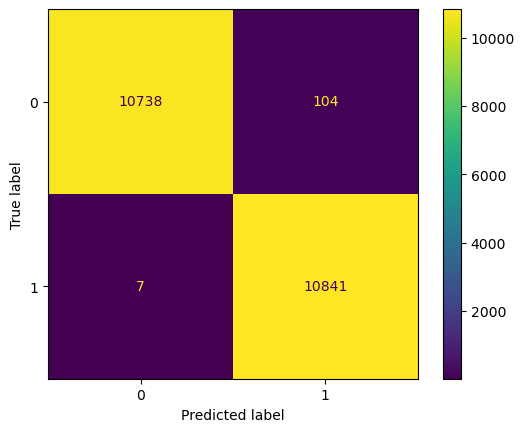

In [11]:
y_pred = tb_catb.predict(X_tb_validate)
print("CATB_TB")
print(classification_report(y_tb_validate, y_pred, digits=4))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

In [12]:
# tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
# tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/TB_Tree"+".svg")
# display(tree)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_IB")

#Saving Model as file
ib_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083532
0:	learn: 0.5342092	test: 0.5346779	best: 0.5346779 (0)	total: 33.2ms	remaining: 33.2s
1:	learn: 0.3912467	test: 0.3919154	best: 0.3919154 (1)	total: 57.7ms	remaining: 28.8s
2:	learn: 0.2969116	test: 0.2972638	best: 0.2972638 (2)	total: 80.7ms	remaining: 26.8s
3:	learn: 0.2315717	test: 0.2323334	best: 0.2323334 (3)	total: 104ms	remaining: 25.9s
4:	learn: 0.1856561	test: 0.1866744	best: 0.1866744 (4)	total: 128ms	remaining: 25.4s
5:	learn: 0.1517244	test: 0.1528914	best: 0.1528914 (5)	total: 150ms	remaining: 24.9s
6:	learn: 0.1277909	test: 0.1290078	best: 0.1290078 (6)	total: 171ms	remaining: 24.2s
7:	learn: 0.1102311	test: 0.1115369	best: 0.1115369 (7)	total: 194ms	remaining: 24.1s
8:	learn: 0.0980510	test: 0.0994652	best: 0.0994652 (8)	total: 218ms	remaining: 24s
9:	learn: 0.0863177	test: 0.0879686	best: 0.0879686 (9)	total: 241ms	remaining: 23.9s
10:	learn: 0.0729704	test: 0.0746957	best: 0.0746957 (10)	total: 265ms	remaining: 23.8s
11:	learn: 0.0633827	

103:	learn: 0.0253497	test: 0.0307891	best: 0.0307890 (102)	total: 2.13s	remaining: 18.3s
104:	learn: 0.0253248	test: 0.0307923	best: 0.0307890 (102)	total: 2.14s	remaining: 18.3s
105:	learn: 0.0253002	test: 0.0307831	best: 0.0307831 (105)	total: 2.16s	remaining: 18.3s
106:	learn: 0.0252784	test: 0.0307643	best: 0.0307643 (106)	total: 2.18s	remaining: 18.2s
107:	learn: 0.0252546	test: 0.0307649	best: 0.0307643 (106)	total: 2.2s	remaining: 18.2s
108:	learn: 0.0252304	test: 0.0307651	best: 0.0307643 (106)	total: 2.22s	remaining: 18.2s
109:	learn: 0.0252076	test: 0.0307630	best: 0.0307630 (109)	total: 2.24s	remaining: 18.1s
110:	learn: 0.0251819	test: 0.0307635	best: 0.0307630 (109)	total: 2.26s	remaining: 18.1s
111:	learn: 0.0251581	test: 0.0307636	best: 0.0307630 (109)	total: 2.28s	remaining: 18.1s
112:	learn: 0.0251063	test: 0.0307520	best: 0.0307520 (112)	total: 2.3s	remaining: 18s
113:	learn: 0.0250824	test: 0.0307607	best: 0.0307520 (112)	total: 2.32s	remaining: 18s
114:	learn: 0.02

201:	learn: 0.0196244	test: 0.0272521	best: 0.0272521 (201)	total: 4.07s	remaining: 16.1s
202:	learn: 0.0196040	test: 0.0272554	best: 0.0272521 (201)	total: 4.1s	remaining: 16.1s
203:	learn: 0.0195921	test: 0.0272556	best: 0.0272521 (201)	total: 4.12s	remaining: 16.1s
204:	learn: 0.0193920	test: 0.0270782	best: 0.0270782 (204)	total: 4.14s	remaining: 16s
205:	learn: 0.0193795	test: 0.0270786	best: 0.0270782 (204)	total: 4.15s	remaining: 16s
206:	learn: 0.0193118	test: 0.0270238	best: 0.0270238 (206)	total: 4.17s	remaining: 16s
207:	learn: 0.0192018	test: 0.0269230	best: 0.0269230 (207)	total: 4.2s	remaining: 16s
208:	learn: 0.0191900	test: 0.0269215	best: 0.0269215 (208)	total: 4.23s	remaining: 16s
209:	learn: 0.0191789	test: 0.0269169	best: 0.0269169 (209)	total: 4.25s	remaining: 16s
210:	learn: 0.0191605	test: 0.0269243	best: 0.0269169 (209)	total: 4.27s	remaining: 16s
211:	learn: 0.0191424	test: 0.0269253	best: 0.0269169 (209)	total: 4.3s	remaining: 16s
212:	learn: 0.0189669	test: 0

294:	learn: 0.0154908	test: 0.0245936	best: 0.0245936 (294)	total: 6.01s	remaining: 14.4s
295:	learn: 0.0154826	test: 0.0245883	best: 0.0245883 (295)	total: 6.08s	remaining: 14.5s
296:	learn: 0.0154762	test: 0.0245949	best: 0.0245883 (295)	total: 6.1s	remaining: 14.4s
297:	learn: 0.0154687	test: 0.0245948	best: 0.0245883 (295)	total: 6.12s	remaining: 14.4s
298:	learn: 0.0154622	test: 0.0245959	best: 0.0245883 (295)	total: 6.14s	remaining: 14.4s
299:	learn: 0.0154055	test: 0.0245453	best: 0.0245453 (299)	total: 6.16s	remaining: 14.4s
300:	learn: 0.0153978	test: 0.0245356	best: 0.0245356 (300)	total: 6.18s	remaining: 14.4s
301:	learn: 0.0153735	test: 0.0245205	best: 0.0245205 (301)	total: 6.2s	remaining: 14.3s
302:	learn: 0.0153277	test: 0.0244929	best: 0.0244929 (302)	total: 6.22s	remaining: 14.3s
303:	learn: 0.0152494	test: 0.0244618	best: 0.0244618 (303)	total: 6.25s	remaining: 14.3s
304:	learn: 0.0152389	test: 0.0244608	best: 0.0244608 (304)	total: 6.27s	remaining: 14.3s
305:	learn: 

390:	learn: 0.0132327	test: 0.0233078	best: 0.0233078 (390)	total: 8s	remaining: 12.5s
391:	learn: 0.0132141	test: 0.0232971	best: 0.0232971 (391)	total: 8.02s	remaining: 12.4s
392:	learn: 0.0132070	test: 0.0232949	best: 0.0232949 (392)	total: 8.04s	remaining: 12.4s
393:	learn: 0.0132023	test: 0.0232944	best: 0.0232944 (393)	total: 8.05s	remaining: 12.4s
394:	learn: 0.0131912	test: 0.0232868	best: 0.0232868 (394)	total: 8.08s	remaining: 12.4s
395:	learn: 0.0131788	test: 0.0232846	best: 0.0232846 (395)	total: 8.09s	remaining: 12.3s
396:	learn: 0.0130524	test: 0.0232008	best: 0.0232008 (396)	total: 8.12s	remaining: 12.3s
397:	learn: 0.0130481	test: 0.0231993	best: 0.0231993 (397)	total: 8.13s	remaining: 12.3s
398:	learn: 0.0130407	test: 0.0231956	best: 0.0231956 (398)	total: 8.16s	remaining: 12.3s
399:	learn: 0.0129932	test: 0.0231712	best: 0.0231712 (399)	total: 8.19s	remaining: 12.3s
400:	learn: 0.0129890	test: 0.0231725	best: 0.0231712 (399)	total: 8.21s	remaining: 12.3s
401:	learn: 0

488:	learn: 0.0117399	test: 0.0223522	best: 0.0223483 (486)	total: 9.9s	remaining: 10.3s
489:	learn: 0.0117399	test: 0.0223522	best: 0.0223483 (486)	total: 9.92s	remaining: 10.3s
490:	learn: 0.0117399	test: 0.0223523	best: 0.0223483 (486)	total: 9.94s	remaining: 10.3s
491:	learn: 0.0117361	test: 0.0223515	best: 0.0223483 (486)	total: 9.96s	remaining: 10.3s
492:	learn: 0.0117301	test: 0.0223531	best: 0.0223483 (486)	total: 9.97s	remaining: 10.3s
493:	learn: 0.0117226	test: 0.0223464	best: 0.0223464 (493)	total: 9.99s	remaining: 10.2s
494:	learn: 0.0117133	test: 0.0223391	best: 0.0223391 (494)	total: 10s	remaining: 10.2s
495:	learn: 0.0117108	test: 0.0223431	best: 0.0223391 (494)	total: 10.1s	remaining: 10.2s
496:	learn: 0.0117045	test: 0.0223494	best: 0.0223391 (494)	total: 10.1s	remaining: 10.2s
497:	learn: 0.0116960	test: 0.0223473	best: 0.0223391 (494)	total: 10.1s	remaining: 10.2s
498:	learn: 0.0116771	test: 0.0223493	best: 0.0223391 (494)	total: 10.1s	remaining: 10.1s
499:	learn: 0

580:	learn: 0.0106600	test: 0.0219140	best: 0.0219140 (580)	total: 11.8s	remaining: 8.55s
581:	learn: 0.0106558	test: 0.0219139	best: 0.0219139 (581)	total: 11.9s	remaining: 8.53s
582:	learn: 0.0106558	test: 0.0219139	best: 0.0219139 (581)	total: 11.9s	remaining: 8.51s
583:	learn: 0.0106516	test: 0.0219176	best: 0.0219139 (581)	total: 11.9s	remaining: 8.49s
584:	learn: 0.0106462	test: 0.0219122	best: 0.0219122 (584)	total: 11.9s	remaining: 8.48s
585:	learn: 0.0106436	test: 0.0219128	best: 0.0219122 (584)	total: 12s	remaining: 8.46s
586:	learn: 0.0106336	test: 0.0219109	best: 0.0219109 (586)	total: 12s	remaining: 8.44s
587:	learn: 0.0106181	test: 0.0219034	best: 0.0219034 (587)	total: 12s	remaining: 8.42s
588:	learn: 0.0106155	test: 0.0219035	best: 0.0219034 (587)	total: 12s	remaining: 8.4s
589:	learn: 0.0106111	test: 0.0219024	best: 0.0219024 (589)	total: 12.1s	remaining: 8.41s
590:	learn: 0.0106060	test: 0.0219014	best: 0.0219014 (590)	total: 12.1s	remaining: 8.4s
591:	learn: 0.010598

675:	learn: 0.0096937	test: 0.0213503	best: 0.0213469 (672)	total: 13.8s	remaining: 6.64s
676:	learn: 0.0096918	test: 0.0213514	best: 0.0213469 (672)	total: 13.9s	remaining: 6.62s
677:	learn: 0.0096890	test: 0.0213529	best: 0.0213469 (672)	total: 13.9s	remaining: 6.6s
678:	learn: 0.0096868	test: 0.0213495	best: 0.0213469 (672)	total: 13.9s	remaining: 6.58s
679:	learn: 0.0096727	test: 0.0213511	best: 0.0213469 (672)	total: 13.9s	remaining: 6.55s
680:	learn: 0.0096725	test: 0.0213508	best: 0.0213469 (672)	total: 13.9s	remaining: 6.53s
681:	learn: 0.0096668	test: 0.0213536	best: 0.0213469 (672)	total: 14s	remaining: 6.51s
682:	learn: 0.0096667	test: 0.0213536	best: 0.0213469 (672)	total: 14s	remaining: 6.49s
683:	learn: 0.0096611	test: 0.0213452	best: 0.0213452 (683)	total: 14s	remaining: 6.47s
684:	learn: 0.0096573	test: 0.0213464	best: 0.0213452 (683)	total: 14s	remaining: 6.45s
685:	learn: 0.0096479	test: 0.0213445	best: 0.0213445 (685)	total: 14s	remaining: 6.43s
686:	learn: 0.0096478

768:	learn: 0.0087953	test: 0.0209291	best: 0.0209291 (768)	total: 15.8s	remaining: 4.74s
769:	learn: 0.0087673	test: 0.0209145	best: 0.0209145 (769)	total: 15.8s	remaining: 4.72s
770:	learn: 0.0087652	test: 0.0209147	best: 0.0209145 (769)	total: 15.8s	remaining: 4.7s
771:	learn: 0.0087285	test: 0.0208760	best: 0.0208760 (771)	total: 15.8s	remaining: 4.68s
772:	learn: 0.0087267	test: 0.0208779	best: 0.0208760 (771)	total: 15.8s	remaining: 4.65s
773:	learn: 0.0087164	test: 0.0208790	best: 0.0208760 (771)	total: 15.9s	remaining: 4.63s
774:	learn: 0.0087145	test: 0.0208810	best: 0.0208760 (771)	total: 15.9s	remaining: 4.61s
775:	learn: 0.0087066	test: 0.0208791	best: 0.0208760 (771)	total: 15.9s	remaining: 4.59s
776:	learn: 0.0087047	test: 0.0208774	best: 0.0208760 (771)	total: 15.9s	remaining: 4.57s
777:	learn: 0.0086897	test: 0.0208800	best: 0.0208760 (771)	total: 15.9s	remaining: 4.55s
778:	learn: 0.0086879	test: 0.0208788	best: 0.0208760 (771)	total: 16s	remaining: 4.53s
779:	learn: 0

867:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 2.7s
868:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 2.68s
869:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 2.66s
870:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 2.64s
871:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 2.62s
872:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.8s	remaining: 2.6s
873:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.9s	remaining: 2.57s
874:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.9s	remaining: 2.55s
875:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.9s	remaining: 2.53s
876:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.9s	remaining: 2.51s
877:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.9s	remaining: 2.49s
878:	learn: 

969:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.7s	remaining: 609ms
970:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.7s	remaining: 588ms
971:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.7s	remaining: 568ms
972:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.7s	remaining: 548ms
973:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.8s	remaining: 527ms
974:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.8s	remaining: 507ms
975:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.8s	remaining: 487ms
976:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.8s	remaining: 466ms
977:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.8s	remaining: 446ms
978:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.8s	remaining: 426ms
979:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 19.9s	remaining: 405ms
980:	learn

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_IB
              precision    recall  f1-score   support

           0     0.9986    0.9916    0.9951     10842
           1     0.9917    0.9986    0.9951     10848

    accuracy                         0.9951     21690
   macro avg     0.9951    0.9951    0.9951     21690
weighted avg     0.9951    0.9951    0.9951     21690



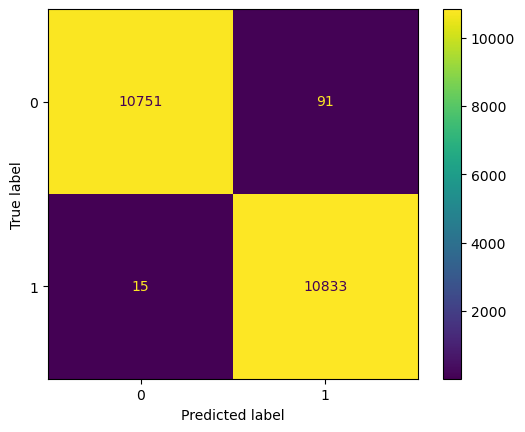

In [14]:
y_pred = ib_catb.predict(X_ib_validate)
print("CATB_IB")
print(classification_report(y_ib_validate, y_pred, digits=4))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

In [15]:
# tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
# tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/IB_Tree"+".svg")
# tree

In [16]:
logging("\n")